### Imports

In [2]:
import copy
import matplotlib.pyplot as plt
import os
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead

from lightly.transforms import utils, SimCLRTransform
from lightly.data import LightlyDataset
from lightly.utils.scheduler import cosine_schedule
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import numpy as np
import json
import lightly.utils.io as io
import torchvision.transforms as transforms
import torch

### Configurable Parameters

In [12]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
train_data = "data/dataset_train"
test_data = "data/dataset_test"
idx_to_class_file = "idx_to_class.json"
checkpoint_path = "simclr_model.ckpt"
embedding_file = "simclr_embeddings.csv"
pl.seed_everything(seed)

Global seed set to 1


1

### DataLoader

Transformation is applied to the dataset, and you can adjust its parameters in accordance with your problem statement. Certain options should be toggled on or off based on your specific requirements. For instance, if differentiating your images relies on colors, you should disable the color jitter option, and so forth.
https://docs.lightly.ai/self-supervised-learning/lightly.transforms.html#lightly.transforms.simclr_transform.SimCLRTransform

In [5]:
transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train = LightlyDataset(input_dir=train_data, transform=transform)

dataset_test = LightlyDataset(input_dir=test_data, transform=test_transform)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

# idx to class is saved in json so we can use it later during inference
idx_to_classes = {v:k for k, v in dataloader_train.dataset.dataset.class_to_idx.items()}
with open(idx_to_class_file, "w") as json_file:
    json.dump(idx_to_classes, json_file)


### Model

If you want to change the backbone, you can change line `resnet = torchvision.models.resnet18()`.

https://pytorch.org/vision/0.15/models/resnet.html?highlight=torchvision+models

In [6]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

#### Training

In [7]:
model = SimCLRModel()
accelerator = "gpu" if torch.cuda.is_available() else "cpu"

trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator=accelerator)
trainer.fit(model=model, train_dataloaders=dataloader_train)

# save model
torch.save(model.state_dict(), checkpoint_path)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/hamzakhan/miniconda3/envs/lightly/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read htt

Epoch 19: 100%|████████████████████████| 38/38 [00:14<00:00,  2.65it/s, v_num=5]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|████████████████████████| 38/38 [00:14<00:00,  2.58it/s, v_num=5]


#### Load Model

In [9]:
# load model
model = SimCLRModel()
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

### Generate Embeddings

In [10]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    labels = []
    with torch.no_grad():
        for img, label_ids, fnames in dataloader:
            img = img[0].to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)
            labels.extend( [int(lab) for lab in label_ids])
            break

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, labels ,filenames


model.eval()
embeddings, labels, filenames= generate_embeddings(model, dataloader_train)

In [13]:
# Save Embeddings
io.save_embeddings(embedding_file, embeddings, labels, filenames)

In [14]:
# Load Embeddings
embeddings, labels, filenames = io.load_embeddings(embedding_file)

#### NN of dataset

In [15]:
with open(idx_to_class_file, "r") as json_file:
    idx_to_classes = json.load(json_file)

In [16]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(train_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")
    return distances, indices

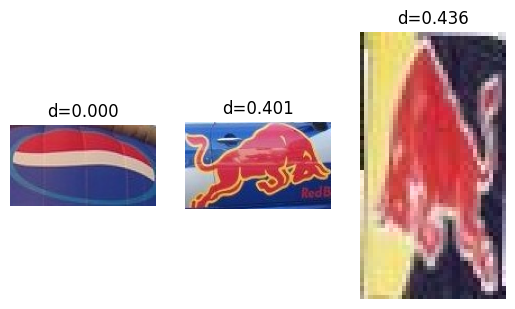

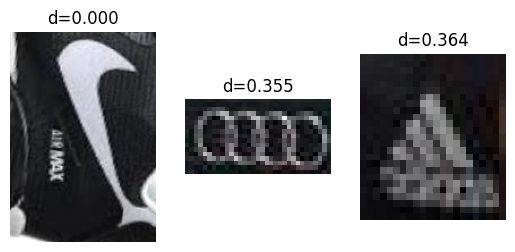

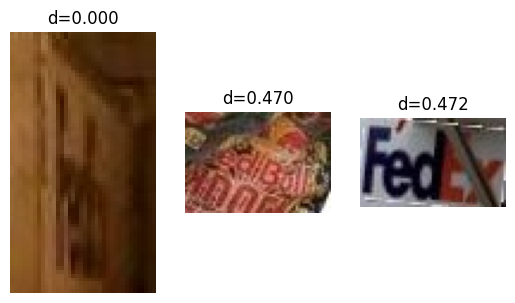

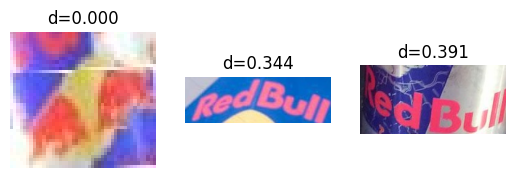

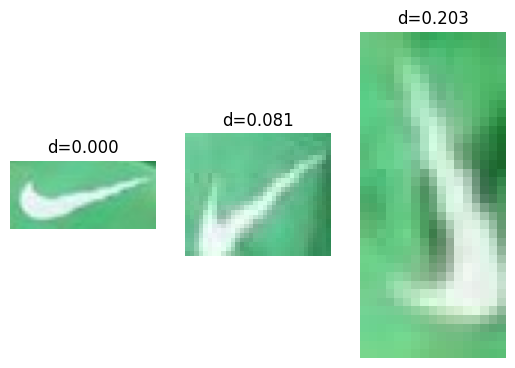

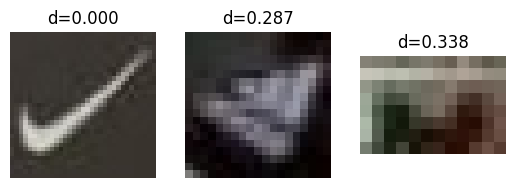

In [17]:
distances, indices = plot_knn_examples(embeddings, filenames)

#### NN of new sample

In [20]:
img = Image.open("audi.jpg")

transformations = transforms.Compose([
    transforms.Resize((input_size, input_size)),  # Resize the image to (256, 256)
    transforms.ToTensor(),          # Convert to a PyTorch tensor
])
image_tensor = transformations(img)
batched_tensor = image_tensor.unsqueeze(0)
with torch.no_grad():
    model.eval()
    query_sample = model.backbone(batched_tensor).flatten(start_dim=1)
query_sample = normalize(query_sample)

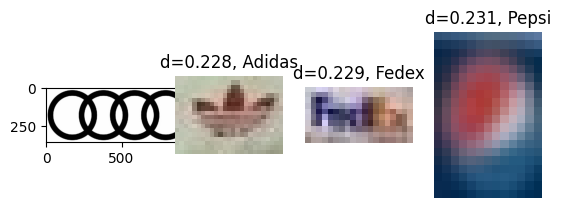

In [58]:
# lets look at the nearest neighbors for some samples
# we use the sklearn library
nbrs = NearestNeighbors(n_neighbors=3).fit(embeddings)

distances, indices = nbrs.kneighbors(query_sample)

fig = plt.figure()
# loop through their nearest neighbors
ax = fig.add_subplot(1, len(indices[0]), 1)
plt.imshow(img)
for plot_x_offset, neighbor_idx in enumerate(indices[0]):
    # add the subplot
    ax = fig.add_subplot(1, len(indices[0])+1, plot_x_offset + 2)
    # get the correponding filename for the current index
    fname = os.path.join(train_data, filenames[neighbor_idx])
    # plot the image
    plt.imshow(get_image_as_np_array(fname))
    # set the title to the distance of the neighbor
    ax.set_title(f"d={distances[0][plot_x_offset]:.3f}, {idx_to_classes[str(labels[neighbor_idx])]}")
    # let's disable the axis
    plt.axis("off")

In [22]:
idx_to_classes

{'0': 'Adidas',
 '1': 'Audi',
 '2': 'Fedex',
 '3': 'Microsoft',
 '4': 'Nike',
 '5': 'Pepsi',
 '6': 'Redbull'}